In [1]:
import os, warnings
import dicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import vtk
from vtk.util import numpy_support
import collections
import xml.etree.ElementTree as ET

from pylab import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

NS = {'nih': 'http://www.nih.gov'}
lidc_path = "/home/felipecdo/medical-imaging/images-TCIA/downloaded-images/DOI/"
verbose = True

class LidcSeries:
    patient =""
    study=""
    series=""
    folder_path=""
    xml_path=""
    dicom_image_paths=[]
    
    def set_xml_info(self,xml_info):
        self.xml_info = xml_info
    def set_image_paths(self,image_paths):
        self.dicom_image_paths = image_paths
    def __str__(self):
        return folder_path
    
    def read_dicom_image(self, position):
        with open(self.dicom_image_paths[position], 'rb') as f:
            return dicom.read_file(f)
        


def get_dicom_paths(path_study):
    folders = []
    for folder_item in os.listdir(path_study):
        if folder_item.endswith('.dcm'):
            path_to_dicom = os.path.join(path_study, folder_item)
            folders.append(path_to_dicom )
    return folders
    
def get_xml_path(path_study):
    for folder_item in os.listdir(path_study):
        if folder_item.endswith('.xml'):
            return os.path.join(path_study, folder_item)

def load_series(lidc_path):
    """
    Load all the DICOM images assocated with this scan and return as list.

    Example:
        >>> scan = pl.query(pl.Scan).first()
        >>> images = scan.load_all_dicom_images()
        >>> zs = [float(img.ImagePositionPatient[2]) for img in images]
        >>> print(zs[1] - zs[0], img.SliceThickness, scan.slice_thickness)
        >>>
        >>> import matplotlib.pyplot as plt
        >>> plt.imshow( images[0].pixel_array, cmap=plt.cm.gray )
        >>> plt.show()
    """
    if verbose: print("Loading dicom files ... This may take a moment.")

    path = lidc_path
    
    #"/patient_id/study_instance_uid/series_instance_uid"
    all_series = []
    
    for patient in os.listdir(path):
        for study in os.listdir(os.path.join(path,patient)):
            for series in os.listdir(os.path.join(path, patient, study)):
                lidcSerie = LidcSeries()
                current_path = os.path.join(path, patient, study, series)
                folders = get_dicom_paths(current_path)        
                xml_path = get_xml_path(current_path)        

                lidcSerie.patient = patient
                lidcSerie.study = study
                lidcSerie.series = series
                lidcSerie.xml_path = xml_path
                lidcSerie.folder_path=current_path
                lidcSerie.set_image_paths(folders)
                all_series.append(lidcSerie)
    
    if verbose: print("Series Count: " + str(len(all_series)))
    
    if verbose: print len(all_series[0].dicom_image_paths)
    if verbose: print len(all_series[1].dicom_image_paths)
    if verbose: print len(all_series[2].dicom_image_paths)
    if verbose: print len(all_series[7].dicom_image_paths)
    
    return all_series


series = load_series(lidc_path)

Loading dicom files ... This may take a moment.
Series Count: 1257
2
129
130
4


In [2]:
# Based on https://github.com/zhwhong/lidc_nodule_detection/blob/master/api_lidc/nodule_structs.py

class NoduleCharacteristics:
    def __init__(self):
        self.subtlety = 0
        self.internal_struct = 0
        self.calcification = 0
        self.sphericity = 0
        self.margin = 0
        self.lobulation = 0
        self.spiculation = 0
        self.texture = 0
        self.malignancy = 0
        return

    def __str__(self):
        str = "subtlty (%d) intstruct (%d) calci (%d) sphere (%d) " \
              "margin (%d) lob (%d) spicul (%d) txtur (%d) malig (%d)" % (
                  self.subtlety, self.internal_struct, self.calcification,
                  self.sphericity,
                  self.margin, self.lobulation, self.spiculation, self.texture,
                  self.malignancy)
        return str

    def set_values(self, sub, inter, calc, spher, lob, spic, tex, malig):
        self.subtlety = sub
        self.internal_struct = inter
        self.calcification = calc
        self.sphericity = spher
        self.lobulation = lob
        self.spiculation = spic
        self.texture = tex
        self.malignancy = malig
        return


class NoduleRoi:  # is common for nodule and non-nodule
    def __init__(self, z_pos=0., sop_uid=''):
        self.z = z_pos
        self.sop_uid = sop_uid
        self.inclusion = True

        self.roi_xy = []  # to hold list of x,ycords in edgemap(edgmap pairs)
        self.roi_rect = []  # rectangle to hold the roi
        self.roi_centroid = []  # to hold centroid of the roi
        return

    def __str__(self):
        n_pts = len(self.roi_xy)
        str = "Inclusion (%s) Z = %.2f SOP_UID (%s) \n ROI points [ %d ]  ::  " \
              "" % (
            self.inclusion, self.z, self.sop_uid, n_pts)

        if (n_pts > 2):
            str += "[[ %d,%d ]] :: " % (
            self.roi_centroid[0], self.roi_centroid[1])
            str += "(%d, %d), (%d,%d)..." % (
                self.roi_xy[0][0], self.roi_xy[0][1], self.roi_xy[1][0],
                self.roi_xy[1][1])
            str += "(%d, %d), (%d,%d)" % (
                self.roi_xy[-2][0], self.roi_xy[-2][1], self.roi_xy[-1][0],
                self.roi_xy[-1][1])
        else:
            for i in range(n_pts):
                str += "(%d, %d)," % (self.roi_xy[i][0], self.roi_xy[i][1])
        return str


class Nodule:  # is base class for all nodule types (NormalNodule,
    # SmallNodule, NonNodule)
    def __init__(self):
        self.id = None
        self.rois = []
        self.is_small = False

    def __str__(self):
        strng = "--- Nodule ID (%s) Small [%s] ---\n" % (
        self.id, str(self.is_small))
        strng += self.tostring() + "\n"
        return strng

    def tostring(self):
        pass


class NoduleAnnotationCluster():  # to be seen
    def __init__(self):
        self.id = []
        self.z_pos = []
        self.centroid = []  # (x,y) of the centroid
        #  convex hull description
        #   p0 ---- p1
        #   |       |
        #   p2-----p3
        self.convex_hull = []  # [()_0 ()_1 ()_2 ()_3]
        self.convex_hull_with_margin = []
        self.no_annots = 0
        self.nodules_data = []

    def compute_centroid(self):
        self.set_convex_hull()
        xc = 0.5 * (
        self.convex_hull[0][0] + self.convex_hull[3][0])  # (x_min + x_max)/2
        yc = 0.5 * (
        self.convex_hull[0][1] + self.convex_hull[3][1])  # (y_min + y_max)/2
        self.centroid = (xc, yc)
        return self.centroid

    def set_convex_hull(self):
        x_min, x_max = 640, 0
        y_min, y_max = 640, 0

        for nodule in self.nodules_data:
            for roi in nodule.rois:
                for dt_pt in roi.roi_xy:
                    # roi.roi_xy -> [(x,y)]
                    # TODO : finish this loop  #?????????????????????????????
                    x_min = dt_pt[0] if (x_min > dt_pt[0]) else x_min
                    x_max = dt_pt[0] if (x_max < dt_pt[0]) else x_max
                    y_min = dt_pt[1] if (y_min > dt_pt[1]) else y_min
                    y_max = dt_pt[1] if (y_max < dt_pt[1]) else y_max
        self.convex_hull = [(x_min, y_min), (x_max, y_min), (x_min, y_max),
                            (x_max, y_max)]
        w, h = (x_max - x_min), (y_max - y_min)
        x_min = int(x_min - 0.15 * w)
        x_max = int(x_max + 0.15 * w)
        y_min = int(y_min - 0.15 * h)
        y_max = int(y_max + 0.15 * h)
        self.convex_hull_with_margin = [(x_min, y_min), (x_max, y_min),
                                        (x_min, y_max),
                                        (x_max, y_max)]


class NormalNodule(Nodule):
    def __init__(self):
        Nodule.__init__(self)
        self.characteristics = NoduleCharacteristics()
        self.is_small = False

    def tostring(self):
        strng = str(self.characteristics)
        strng += "\n"

        for roi in self.rois:
            strng += str(
                roi) + "\n"  # str calls __str__ of NoduleRoi's class
            # i.e.converting roi to
        return strng  # string to prepare it for printing(it doesn't print it)


class SmallNodule(Nodule):
    def __init__(self):
        Nodule.__init__(self)
        self.is_small = True

    def tostring(self):
        strng = ''
        for roi in self.rois:
            strng += str(roi) + "\n"
        return strng


class NonNodule(Nodule):
    def __init__(self):
        Nodule.__init__(self)
        self.is_small = True

    def tostring(self):
        strng = ''
        for roi in self.rois:
            strng += str(roi)
        return strng


class RadAnnotation:
    def __init__(self, init=True):
        self.version = None
        self.id = None

        self.nodules = []  # is normalNodule i.e in xml unblindedReadNodule
        # with characteristics info
        self.non_nodules = []  # located inside readingSession
        self.initialized = init
        return

    def is_init(self):
        return self.initialized

    def set_init(self, init):
        self.initialized = init
        return

    def __str__(self):
        n_nodules = len(self.nodules)
        n_non_nodules = len(self.non_nodules)
        strng = "Annotation Version [%s] Radiologist ID [%s] \n" % (
        self.version, self.id)
        strng += "#Nodules [%d] #NonNodules[%d] \n" % (
            n_nodules, n_non_nodules)

        if (n_nodules > 0):
            strng += "--- Nodules [%d]---\n" % n_nodules
            for i in range(n_nodules):
                strng += str(self.nodules[i])

        if (n_non_nodules > 0):
            strng += "--- Non Nodules [%d] ---\n" % n_non_nodules
            for i in range(n_non_nodules):
                strng += str(self.non_nodules[i])

        strng += "-" * 79 + "\n"
        return strng


class IdriReadMessage:
    def __init__(self):
        self.header = AnnotationHeader()
        self.annotations = []

class AnnotationHeader:
    def __init__(
            self):  # 4 elements are not included b/c they don't have data
        # inside
        self.version = None
        self.message_id = None
        self.date_request = None
        self.time_request = None
        self.task_desc = None
        self.series_instance_uid = None
        self.date_service = None
        self.time_service = None
        self.study_instance_uid = None

    def __str__(self):
        str = ("--- XML HEADER ---\n"
               "Version (%s) Message-Id (%s) Date-request (%s) Time-request ("
               "%s) \n"
               "Series-UID (%s)\n"
               "Time-service (%s) Task-descr (%s) Date-service (%s) "
               "Time-service (%s)\n"
               "Study-UID (%s)") % (
                  self.version, self.message_id, self.date_request,
                  self.time_request,
                  self.series_instance_uid, self.time_service, self.task_desc,
                  self.date_service,
                  self.time_service, self.study_instance_uid)
        return str


def parse_nodule(xml_node):  # xml_node is one unblindedReadNodule
    char_node = xml_node.find('nih:characteristics', NS)
    # if no characteristics, it is smallnodule  i.e. is_small=TRUE
    is_small = (char_node is None or len(char_node) == 0)
    nodule = is_small and SmallNodule() or NormalNodule()
    nodule.id = xml_node.find('nih:noduleID', NS).text
    if not is_small:
        subtlety = char_node.find('nih:subtlety', NS)
        nodule.characteristics.subtlety = int(subtlety.text)
        nodule.characteristics.internal_struct = \
            int(char_node.find('nih:internalStructure', NS).text)
        nodule.characteristics.calcification = \
            int(char_node.find('nih:calcification', NS).text)
        nodule.characteristics.sphericity = \
            int(char_node.find('nih:sphericity', NS).text)
        nodule.characteristics.margin = \
            int(char_node.find('nih:margin', NS).text)
        nodule.characteristics.lobulation = \
            int(char_node.find('nih:lobulation', NS).text)
        nodule.characteristics.spiculation = \
            int(char_node.find('nih:spiculation', NS).text)
        nodule.characteristics.texture = \
            int(char_node.find('nih:texture', NS).text)
        nodule.characteristics.malignancy = \
            int(char_node.find('nih:malignancy', NS).text)
    xml_rois = xml_node.findall('nih:roi', NS)
    for xml_roi in xml_rois:
        roi = NoduleRoi()
        roi.z = float(xml_roi.find('nih:imageZposition', NS).text)
        roi.sop_uid = xml_roi.find('nih:imageSOP_UID', NS).text
        # when inclusion = TRUE ->roi includes the whole nodule
        # when inclusion = FALSE ->roi is drown twice for one nodule
        # 1.ouside the nodule
        # 2.inside the nodule -> to indicate that the nodule has donut
        # hole(the inside hole is
        # not part of the nodule) but by forcing inclusion to be TRUE,
        # this situation is ignored
        roi.inclusion = (xml_roi.find('nih:inclusion', NS).text == "TRUE")
        edge_maps = xml_roi.findall('nih:edgeMap', NS)
        for edge_map in edge_maps:
            x = int(edge_map.find('nih:xCoord', NS).text)
            y = int(edge_map.find('nih:yCoord', NS).text)
            roi.roi_xy.append([x, y])
        xmax = np.array(roi.roi_xy)[:, 0].max()
        xmin = np.array(roi.roi_xy)[:, 0].min()
        ymax = np.array(roi.roi_xy)[:, 1].max()
        ymin = np.array(roi.roi_xy)[:, 1].min()
        if not is_small:  # only for normalNodules
            roi.roi_rect = (xmin, ymin, xmax, ymax)
            roi.roi_centroid = (
                (xmax + xmin) / 2., (ymin + ymax) / 2.)  # center point
        nodule.rois.append(roi)
    return nodule  # is equivalent to unblindedReadNodule(xml element)


def parse_non_nodule(xml_node):  # xml_node is one nonNodule
    nodule = NonNodule()
    nodule.id = xml_node.find('nih:nonNoduleID', NS).text
    roi = NoduleRoi()
    roi.z = float(xml_node.find('nih:imageZposition', NS).text)
    roi.sop_uid = xml_node.find('nih:imageSOP_UID', NS).text
    loci = xml_node.findall('nih:locus', NS)
    for locus in loci:
        x = int(locus.find('nih:xCoord', NS).text)
        y = int(locus.find('nih:yCoord', NS).text)
        roi.roi_xy.append((x, y))
    nodule.rois.append(roi)
    return nodule  # is equivalent to nonNodule(xml element)

    
def parse_header(root):
    header = AnnotationHeader()
    resp_hdr = root.findall('nih:ResponseHeader', NS)[0]
    header.version = resp_hdr.find('nih:Version', NS).text
    header.message_id = resp_hdr.find('nih:MessageId', NS).text
    header.date_request = resp_hdr.find('nih:DateRequest', NS).text
    header.time_request = resp_hdr.find('nih:TimeRequest', NS).text
    header.task_desc = resp_hdr.find('nih:TaskDescription', NS).text
    header.series_instance_uid = resp_hdr.find('nih:SeriesInstanceUid', NS).text
    date_service = resp_hdr.find('nih:DateService', NS)
    if date_service is not None:
        header.date_service = date_service.text
    time_service = resp_hdr.find('nih:TimeService', NS)
    if time_service is not None:
        header.time_service = time_service.text
    header.study_instance_uid = resp_hdr.find('nih:StudyInstanceUID', NS).text
    return header

class XmlInfo:
    def __init__(self, annotation_header, annotations):
        self.header = annotation_header
        self.annotations = annotations
        
def parse_xml_file(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    header = parse_header(root)

    annotations = []
    # header = parse_header(root)
    # readingSession-> holds radiologist's annotation info
    for read_session in root.findall('nih:readingSession', NS):
        # to hold each radiologists annotation
        # i.e. readingSession in xml file
        rad_annotation = RadAnnotation()
        rad_annotation.version = \
            read_session.find('nih:annotationVersion', NS).text
        rad_annotation.id = \
            read_session.find('nih:servicingRadiologistID', NS).text

        # nodules
        nodule_nodes = read_session.findall('nih:unblindedReadNodule', NS)
        for node in nodule_nodes:
            nodule = parse_nodule(node)
            rad_annotation.nodules.append(nodule)

        # non-nodules
        non_nodule = read_session.findall('nih:nonNodule', NS)
        for node in non_nodule:
            nodule = parse_non_nodule(node)
            rad_annotation.non_nodules.append(nodule)
        annotations.append(rad_annotation)
    return XmlInfo(header, annotations)

## Parse XML 138

In [13]:
print series[138].xml_path
print series[3].xml_path

#parse xml
current_series = series[3]
xml_path = current_series.xml_path
xml_info = parse_xml_file(xml_path)
current_series.set_xml_info(xml_info)
#print current_series.xml_info.header
print current_series.xml_info.annotations
print "###################"
print current_series.xml_info.annotations[0]
print "###################"
print current_series.xml_info.annotations[1]
print "###################"
print current_series.xml_info.annotations[2]
print "###################"
print current_series.xml_info.annotations[3]


/home/felipecdo/medical-imaging/images-TCIA/downloaded-images/DOI/LIDC-IDRI-0181/1.3.6.1.4.1.14519.5.2.1.6279.6001.150188222462440903489565305064/1.3.6.1.4.1.14519.5.2.1.6279.6001.243094273518213382155770295147/117.xml
/home/felipecdo/medical-imaging/images-TCIA/downloaded-images/DOI/LIDC-IDRI-0476/1.3.6.1.4.1.14519.5.2.1.6279.6001.837252783245693412667023877670/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143/220.xml
[<__main__.RadAnnotation instance at 0x7f66d27f7128>, <__main__.RadAnnotation instance at 0x7f66d26247a0>, <__main__.RadAnnotation instance at 0x7f66d2642dd0>, <__main__.RadAnnotation instance at 0x7f66d1e54368>]
###################
Annotation Version [3.12] Radiologist ID [anon] 
#Nodules [10] #NonNodules[2] 
--- Nodules [10]---
--- Nodule ID (IL057_196231) Small [False] ---
subtlty (5) intstruct (1) calci (6) sphere (4) margin (5) lob (1) spicul (1) txtur (5) malig (4)
Inclusion (True) Z = -144.00 SOP_UID (1.3.6.1.4.1.14519.5.2.1.6279.6001.84069485456148

## Run Sample

In [4]:
def sample_stack_z(stack, rows=4, cols=4, start_with=30, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=(17,15))
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[:,:,ind], cmap=plt.cm.bone, interpolation='hanning', aspect='auto')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()


def sample_stack_y(stack, rows=4, cols=4, start_with=150, show_every=15):
    fig,ax = plt.subplots(rows,cols,figsize=(17,15))
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(np.rot90(stack[:,ind,:]), cmap=plt.cm.bone, interpolation='hanning', aspect='auto')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

def sample_stack_x(stack, rows=4, cols=4, start_with=150, show_every=15):
    fig,ax = plt.subplots(rows,cols,figsize=(17,15))
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(np.rot90(stack[ind,:,:]), cmap=plt.cm.bone, interpolation='hanning', aspect='auto')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

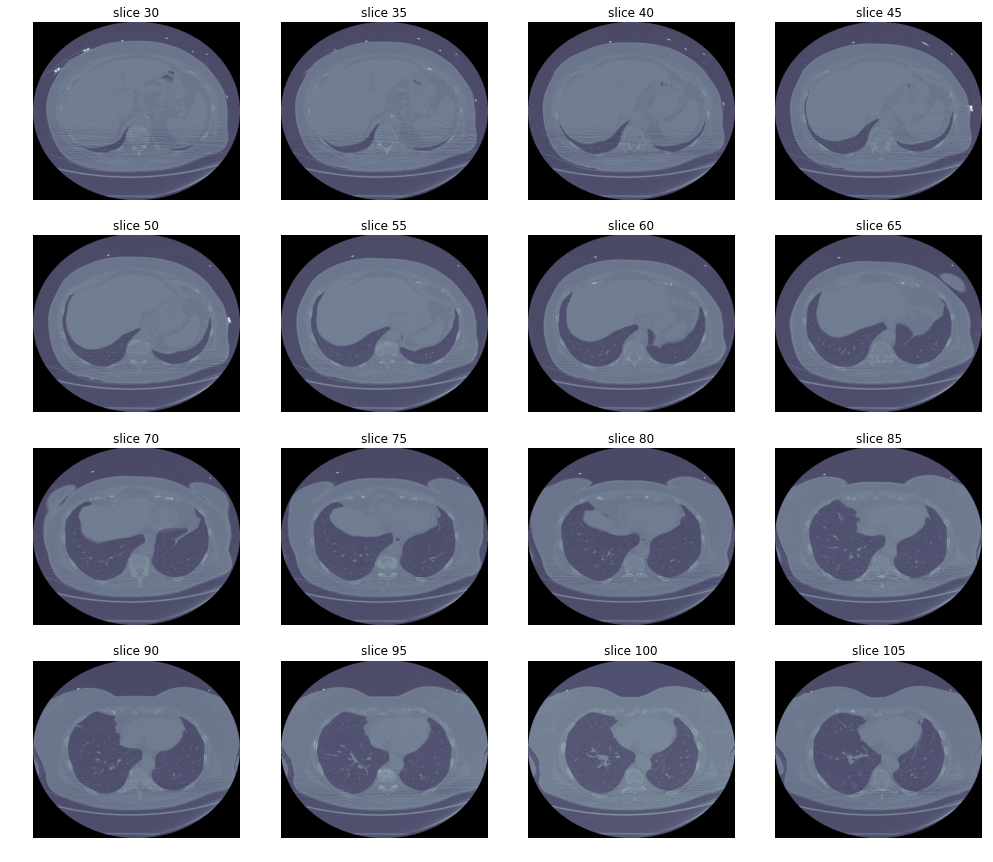

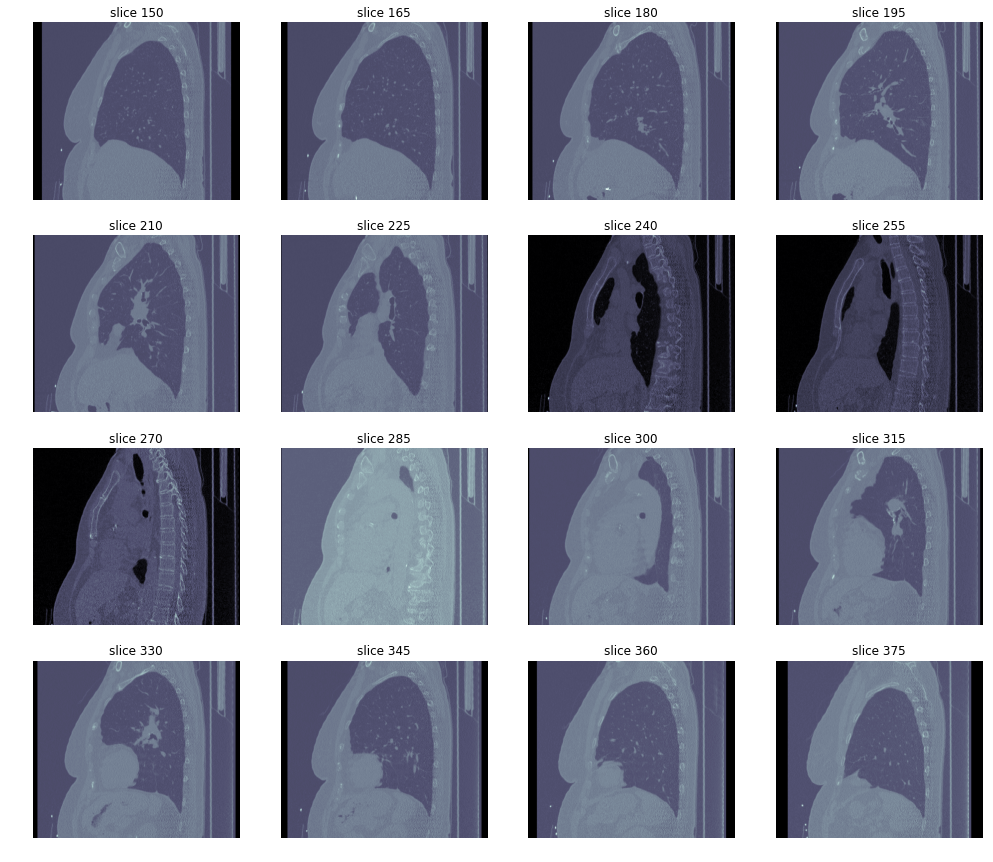

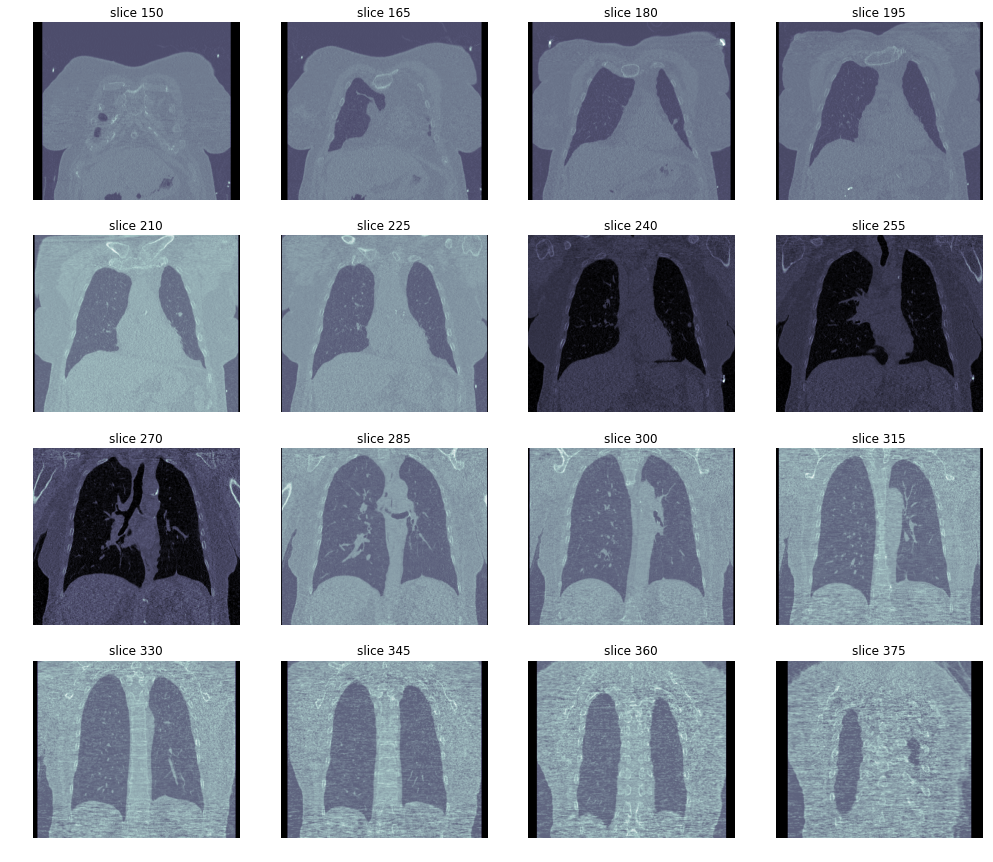

In [5]:
# Calculate dimensions
first_image_path = current_series.dicom_image_paths[0]
RefDs = dicom.read_file(first_image_path)
len_lstFilesDCM = len(current_series.dicom_image_paths)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len_lstFilesDCM)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])


# Load 3D image indexed by axis
dictionary_by_location = {}

for i in range (0,len(current_series.dicom_image_paths)):
    ds = current_series.read_dicom_image(i)
    dictionary_by_location[ds.SliceLocation] = ds

ordered_dict = collections.OrderedDict(sorted(dictionary_by_location.items()))

ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
ind = 0
for key, value in ordered_dict.items():
    ArrayDicom[:, :, ind] = value.pixel_array
    ind+=1

sample_stack_z(ArrayDicom)
sample_stack_y(ArrayDicom)
sample_stack_x(ArrayDicom)


## Zoom in some images

(512, 512, 246)


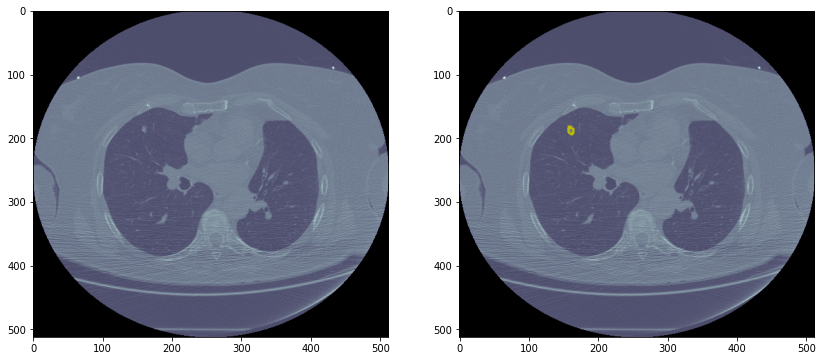

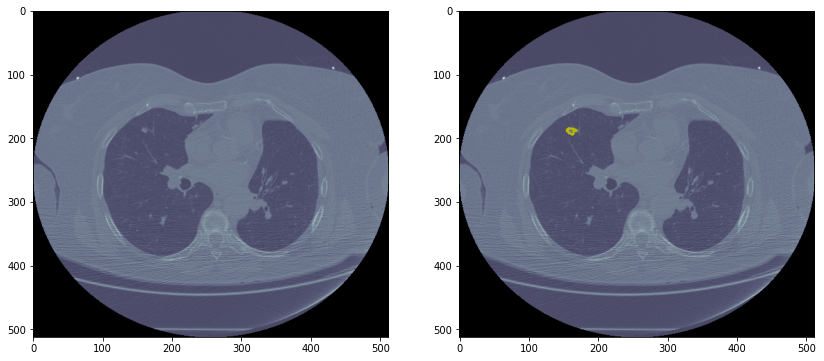

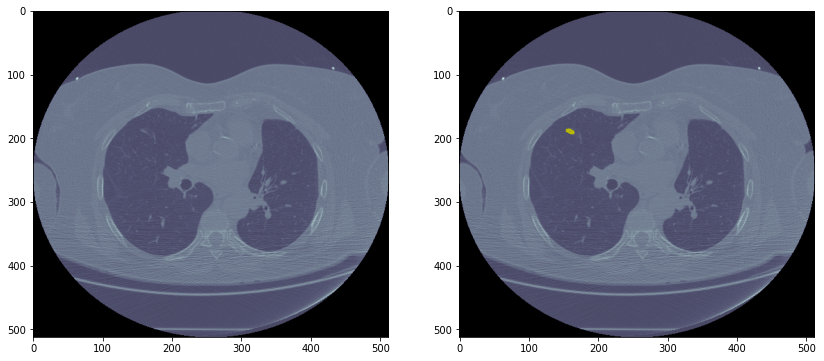

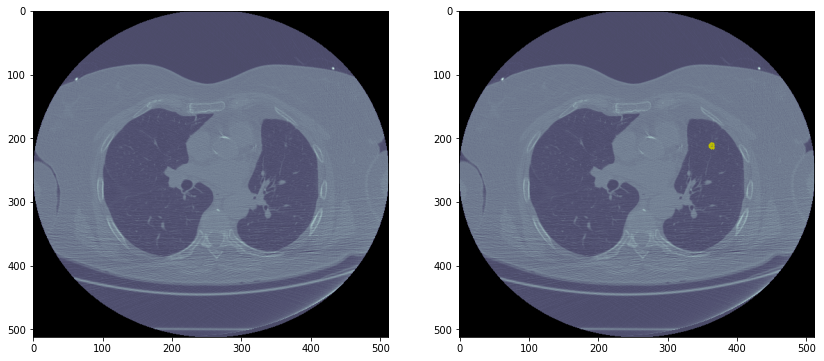

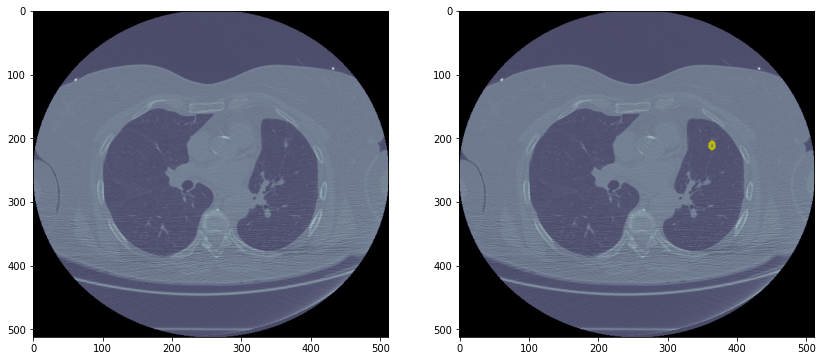

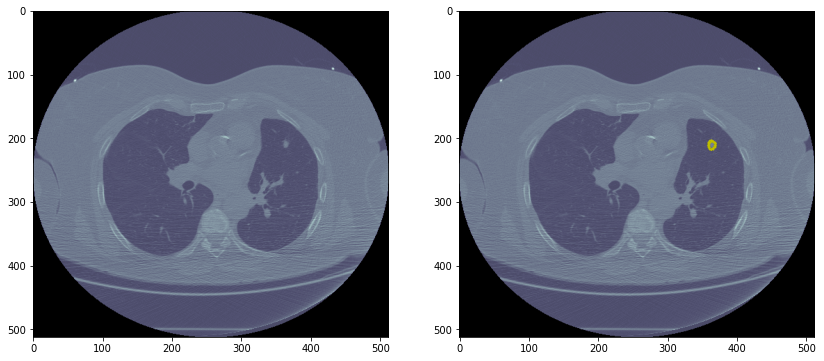

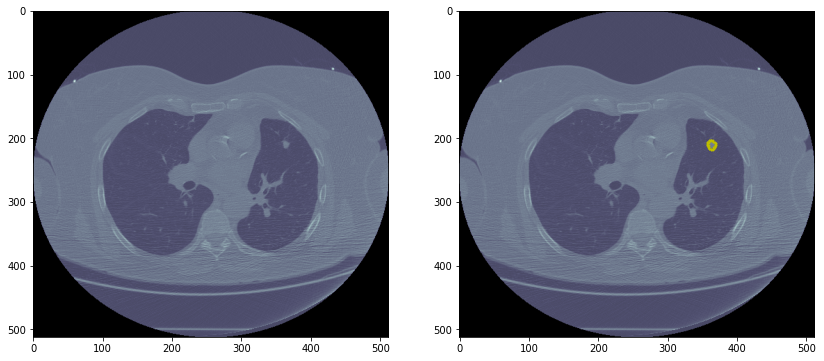

120 274 186


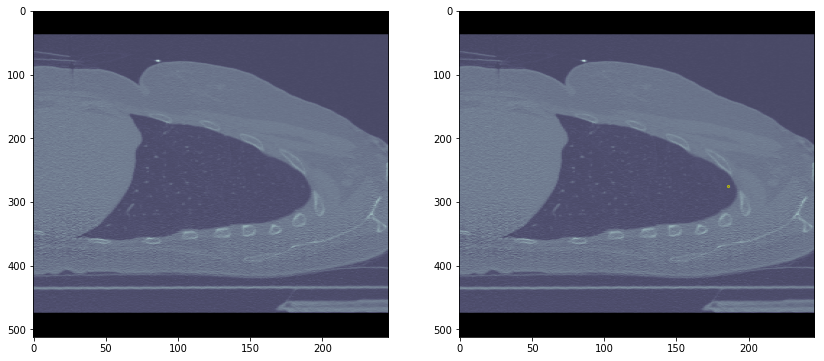

121 276 186
121 276 186


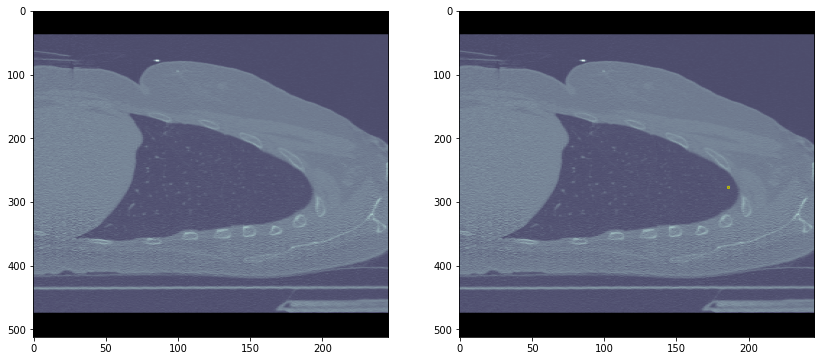

126 239 135
126 239 135


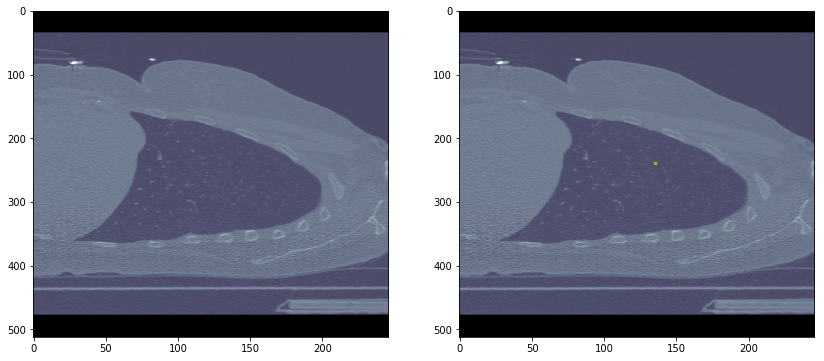

154 186 130
154 187 130
154 186 129
154 187 129
154 188 129
154 188 130


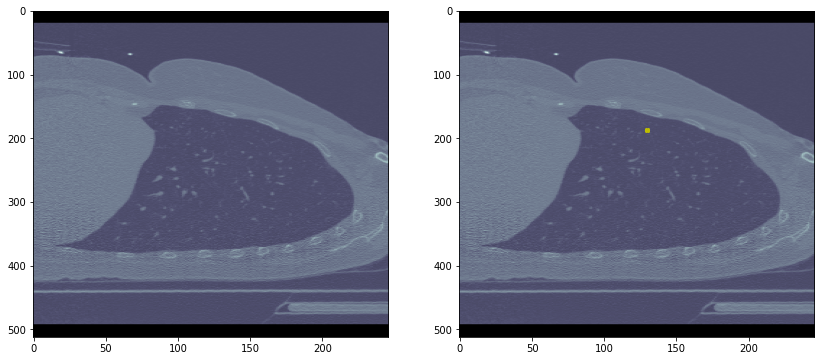

155 185 130
155 188 130
155 187 129
155 188 129
155 188 127
155 184 129
155 185 129
155 189 129
155 187 130
155 189 130
155 186 129
155 187 129
155 188 129
155 189 129
155 183 127
155 188 127
155 187 126


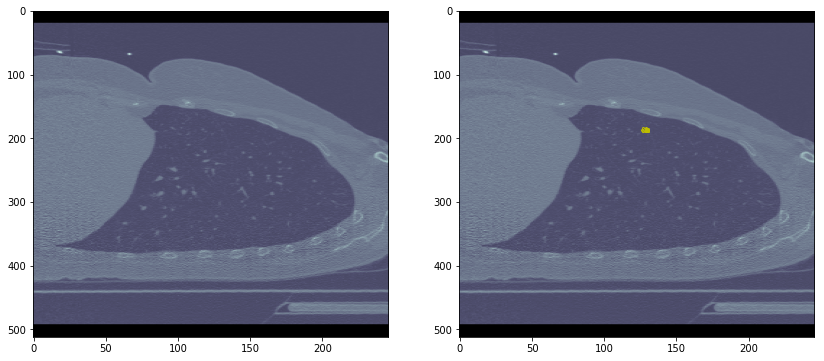

156 185 130
156 189 130
156 184 129
156 185 129
156 186 129
156 189 129
156 185 128
156 186 128
156 187 128
156 188 128
156 189 128
156 183 127
156 184 127
156 185 127
156 186 127
156 187 127
156 189 127
156 182 127
156 183 127
156 184 127
156 185 127
156 186 127
156 187 127
156 188 127
156 181 128
156 182 128
156 183 128
156 184 128
156 185 128
156 186 128
156 187 128
156 188 128
156 183 129
156 189 129
156 183 129
156 186 130
156 189 130
156 184 129
156 185 129
156 190 129
156 183 128
156 184 128
156 185 128
156 186 128
156 187 128
156 188 128
156 189 128
156 190 128
156 182 127
156 184 127
156 185 127
156 186 127
156 187 127
156 189 127
156 186 126
156 188 126


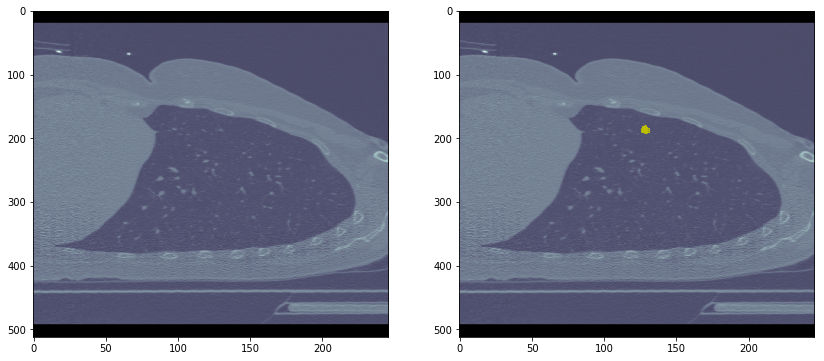

157 185 130
157 189 130
157 183 129
157 190 129
157 182 128
157 183 128
157 184 128
157 190 128
157 182 127
157 190 127
157 181 127
157 189 127
157 190 127
157 180 128
157 189 128
157 180 128
157 190 129
157 183 129
157 186 130
157 190 130
157 183 129
157 191 129
157 182 128
157 190 128
157 182 127
157 190 127
157 185 126
157 189 126
157 190 126


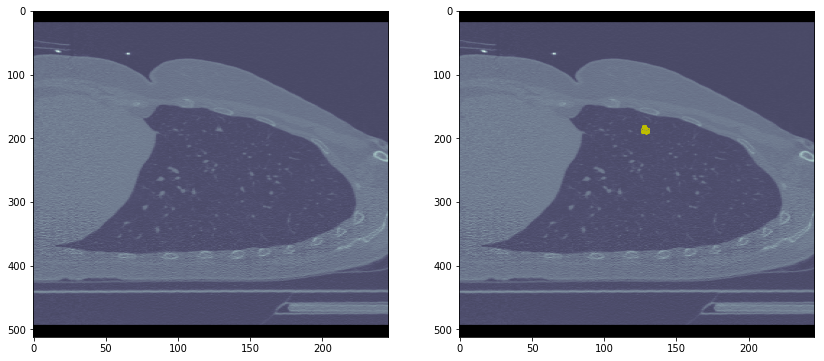

----------------------


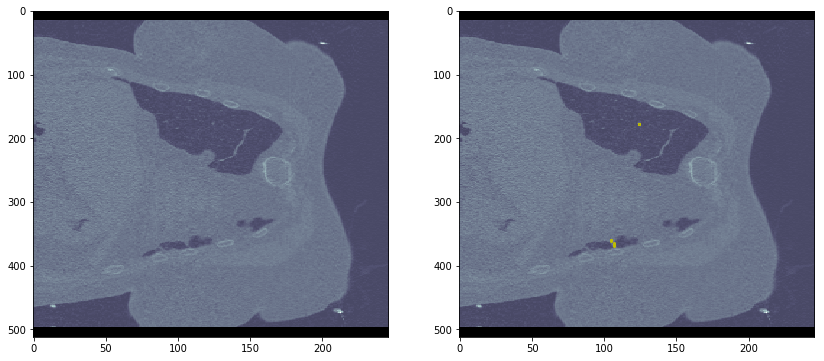

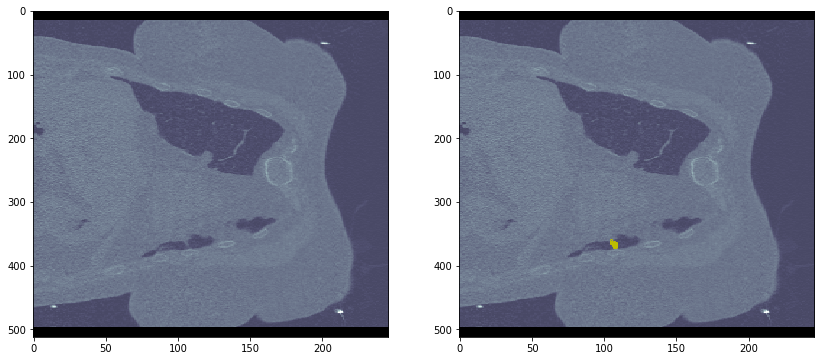

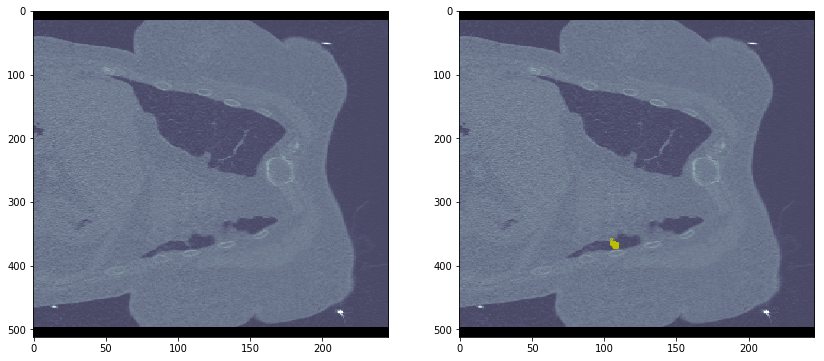

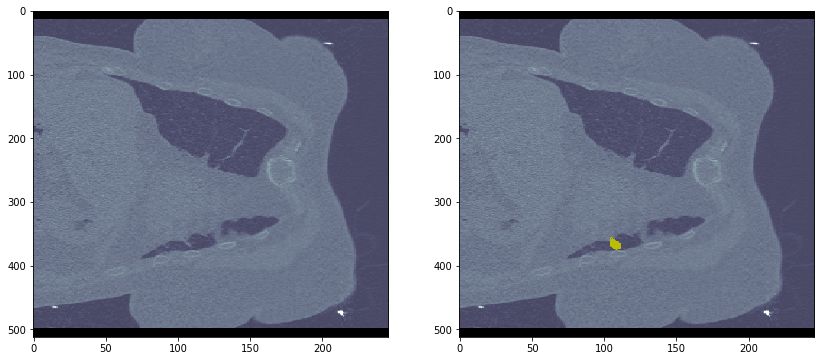

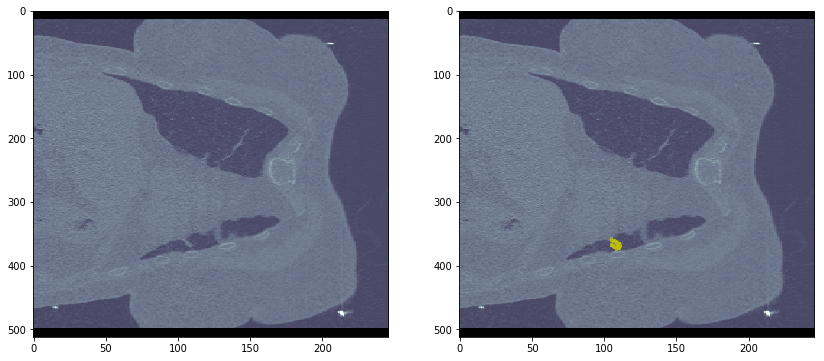

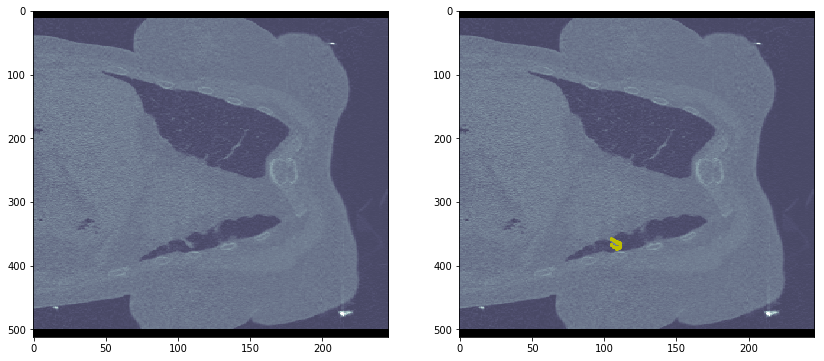

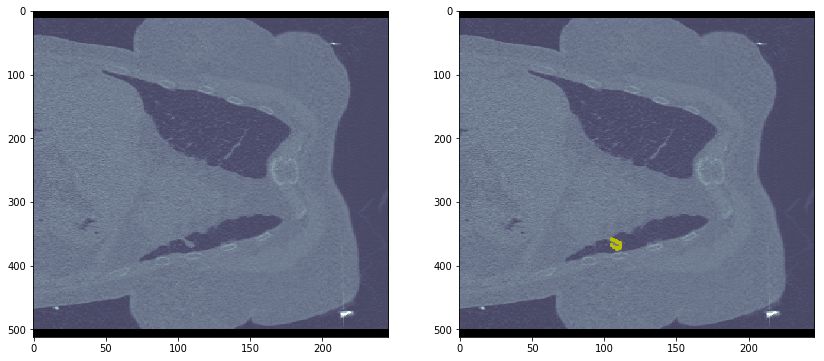

In [6]:
class SegmentationPoint:
    def __init__(self,x,y,z,specialist_index,nodule):
        self.x = x
        self.y = y
        self.z = z
        self.specialist_index = specialist_index
        self.nodule = nodule
        
    def __str__(self):
        return "[{}, {}, {}] - {} - {}".format(self.x,self.y,self.z,self.specialist_index,self.nodule)

def init_array_and_append(dictionary,key,value):
    if key not in dictionary:
        dictionary[key] =[]
    dictionary[key].append(value)
    
class SegmentationPoints:
    def __init__(self):
        self.points = []
        self.by_x = {}
        self.by_y = {}
        self.by_z = {}
    
    def append(self,point):
        self.points.append(point)
        init_array_and_append(self.by_x,point.x,point)
        init_array_and_append(self.by_y,point.y,point)
        init_array_and_append(self.by_z,point.z,point)

    def __str__(self):
        str_accumulate = ""
        for point in self.points:
           str_accumulate += str(point) +"\n"
        return str_accumulate

dictionary_by_location = {}

for i in range (0,len(current_series.dicom_image_paths)):
    ds = current_series.read_dicom_image(i)
    dictionary_by_location[ds.SliceLocation] = ds

ordered_dict = collections.OrderedDict(sorted(dictionary_by_location.items()))
ordered_dict_keys = ordered_dict.keys()

min_value = ordered_dict_keys[0]

ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
ind = 0
for key, value in ordered_dict.items():
    ArrayDicom[:, :, ind] = value.pixel_array
    ind+=1

points = SegmentationPoints()


for i in range(len(current_series.xml_info.annotations)):
    annotation = current_series.xml_info.annotations[i]
    for nodule in annotation.nodules:
        for roi in nodule.rois:
            for point in roi.roi_xy:
                current_z = int((roi.z - min_value) / ds.SliceThickness )
                points.append(SegmentationPoint(point[0],point[1],current_z,i,nodule.id))

#print points
print ArrayDicom.shape

i = 0
for key, seg_points in points.by_z.items():
    #if(89 <key and key<100):
    if(True):
        current_img = ArrayDicom[:,:,key]
        #print current_img.shape

        fig, ax = plt.subplots(1,2,figsize=(14, 6))
        ax[0].imshow(current_img, cmap=plt.cm.bone, aspect='auto', interpolation='hanning')
        
        ax[1].imshow(current_img, cmap=plt.cm.bone, aspect='auto', interpolation='hanning')

        #print "z",key

        rois_x = []
        rois_y = []
        for point in seg_points:
        #    print point.x ,point.y, point.z
            rois_x.append(point.x)
            rois_y.append(point.y)
        ax[1].plot(rois_x,rois_y, 'ro',  markersize=0.5, markerfacecolor='none', markeredgecolor='y')

        plt.show()
        i+=1
        if(i>6):
            break


i = 0
for key, seg_points in points.by_x.items():
    #if(330 <key and key<360) or (250 <key and key<270):
    if(True):
        current_img = ArrayDicom[:,key,:]

        fig, ax = plt.subplots(1,2,figsize=(14, 6))
        ax[0].imshow(current_img, cmap=plt.cm.bone, aspect='auto', interpolation='hanning')
        ax[1].imshow(current_img, cmap=plt.cm.bone, aspect='auto', interpolation='hanning')

        rois_x = []
        rois_y = []
        for point in seg_points:
            print point.x ,point.y ,point.z
            rois_x.append(point.z)
            rois_y.append(point.y)
        ax[1].plot(rois_x,rois_y, 'ro',  markersize=2, markerfacecolor='none', markeredgecolor='y')

        plt.show()
        i+=1
        if(i>6):
            break

        
print "----------------------"
i = 0
for key, seg_points in points.by_y.items():
    #if(330 <key and key<360) or (250 <key and key<270):
    if(True):
        #why "y" we need to fix the first position?
        current_img = ArrayDicom[key,:,:]
        #print current_img.shape
        
        fig, ax = plt.subplots(1,2,figsize=(14, 6))
        ax[0].imshow(current_img, cmap=plt.cm.bone, aspect='auto')

        ax[1].imshow(current_img, cmap=plt.cm.bone, aspect='auto')

        rois_x = []
        rois_y = []
        for point in seg_points:
            #print point.x, point.y, point.z
            rois_x.append(point.z)
            rois_y.append(point.x)
        ax[1].plot(rois_x,rois_y, 'ro',  markersize=2, markerfacecolor='none', markeredgecolor='y')

        plt.show()
        i+=1
        if(i>6):
            break


## Testing 3D algorithm

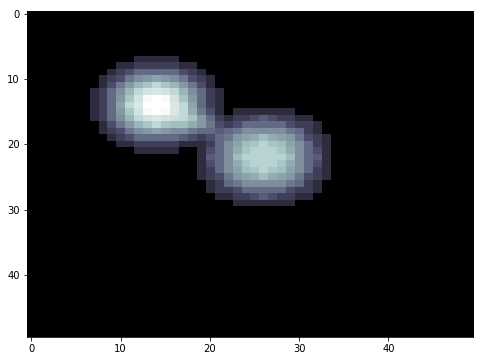

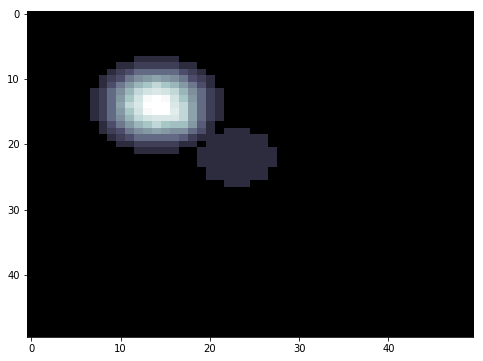

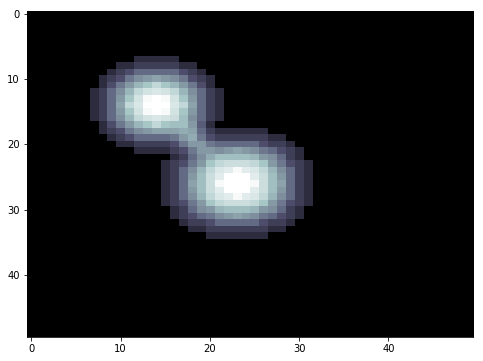

In [7]:
# Generate an initial image with two overlapping circles
x, y, z = np.indices((50, 50, 50))
x1, y1, z1, x2, y2, z2, x3, y3, z3 = 14, 14, 14, 22, 26, 23, 27, 32, 22
r1, r2, r3 = 8, 10, 5
mask_circle1 = (x - x1)**2 + (y - y1)**2 + (z - z1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 + (z - z2)**2 < r2**2
mask_circle3 = (x - x3)**2 + (y - y3)**2 + (z - z3)**2 < r3**2
image = np.logical_or(mask_circle1, mask_circle2, mask_circle3)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance_image = ndi.distance_transform_edt(image)

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(distance_image[:,:,17], cmap=plt.cm.bone, aspect='auto')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(distance_image[:,17,:], cmap=plt.cm.bone, aspect='auto')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(distance_image[17,:,:], cmap=plt.cm.bone, aspect='auto')
plt.show()



[10.0, 8.0, 6.0, 4.0, 2.0, 0.0]
(40, 50, 30)
one image
one image
one image
one image
one image
one image


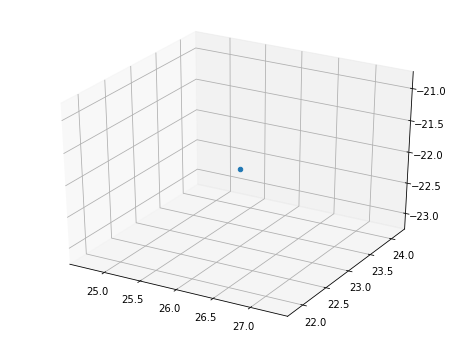

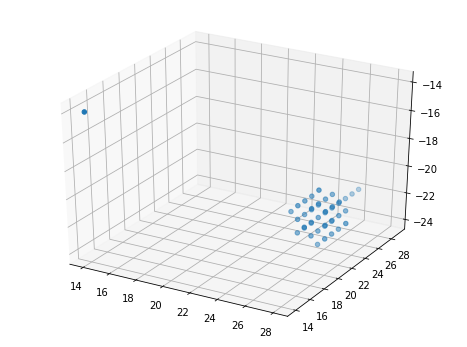

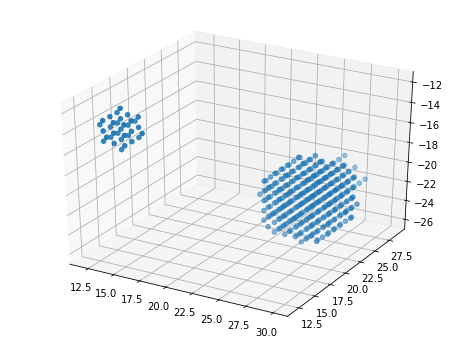

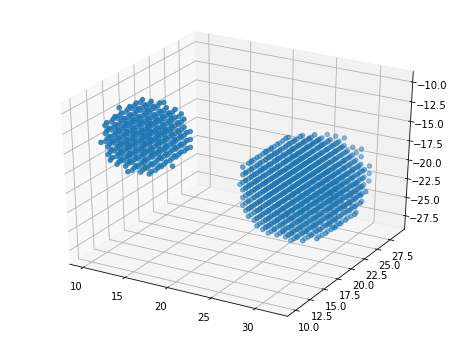

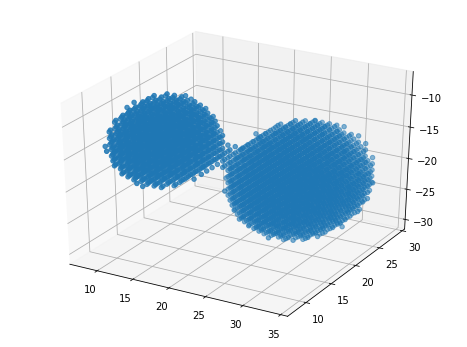

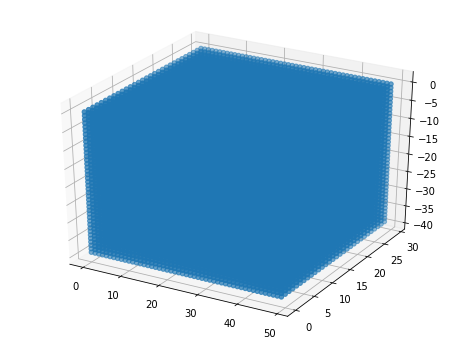

In [8]:
# Generate an initial image with two overlapping circles
x, y, z = np.indices((40, 50, 30))
x1, y1, z1, x2, y2, z2, x3, y3, z3 = 14, 14, 14, 22, 26, 23, 27, 32, 22
r1, r2, r3 = 8, 10, 5
mask_circle1 = (x - x1)**2 + (y - y1)**2 + (z - z1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 + (z - z2)**2 < r2**2
mask_circle3 = (x - x3)**2 + (y - y3)**2 + (z - z3)**2 < r3**2
image = np.logical_or(mask_circle1, mask_circle2, mask_circle3)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance_image = ndi.distance_transform_edt(image)

def get_equal_step_levels(image, level_count=5):
    pyramid_levels = []
    max_value = np.max(image)
    min_value = np.min(image)
    step = (max_value - min_value) / float(level_count)
    current_value = max_value
    while current_value >= min_value:
        pyramid_levels.append(current_value)
        current_value=current_value - step
    return pyramid_levels

def get_watershed_pyramid(source_image, levels):
    print levels
    watershed_pyramid = []
    
    print source_image.shape
    i_size = source_image.shape[0]
    j_size = source_image.shape[1]
    k_size = source_image.shape[2]
    
    for level in levels:
        result_image = np.where(source_image >= level,1,0)
        watershed_pyramid.append(result_image)
        
        print "one image"
        
    return watershed_pyramid

def get_min_pyramid_level(watershed_pyramid, point):
    for level in range(len(watershed_pyramid)-1,-1,-1):
        if watershed_pyramid[level][point] == 0:
            return level
    return None

watershed_pyramid = get_watershed_pyramid(distance_image, get_equal_step_levels(distance_image))
    
from mpl_toolkits.mplot3d import Axes3D

for image in watershed_pyramid:
    fig = plt.figure(figsize=(8,6))
    z,x,y = image.nonzero()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, -z, zdir='z')

    plt.show()

## Apply to medical imaging

In [9]:
current_series = series[138]
first_image_path = current_series.dicom_image_paths[0]
RefDs = dicom.read_file(first_image_path)
len_lstFilesDCM = len(current_series.dicom_image_paths)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len_lstFilesDCM)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

dictionary_by_location = {}

for i in range (0,len(current_series.dicom_image_paths)):
    ds = current_series.read_dicom_image(i)
    dictionary_by_location[ds.SliceLocation] = ds

ordered_dict = collections.OrderedDict(sorted(dictionary_by_location.items()))

ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
ind = 0
for key, value in ordered_dict.items():
    ArrayDicom[:, :, ind] = value.pixel_array
    ind+=1

image_3d = ArrayDicom
    
levels = get_equal_step_levels(image_3d,5)
# USING A LOT OF MEMORY. REVIEW IT
watershed_pyramid = get_watershed_pyramid(image_3d, levels)

print "Result"


#for image in watershed_pyramid:
#    fig = plt.figure(figsize=(8,6))
#    z,x,y = image.nonzero()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(x, y, -z, zdir='z', cmap=plt.cm.bone)

#    plt.show()


[4095, 3071.1999999999998, 2047.3999999999999, 1023.5999999999999, -0.20000000000004547, -1024.0]
(512, 512, 150)
one image
one image
one image
one image
one image
one image
Result


## User select one point


In [10]:
user_point = (157, 189, 127)

min_pyramid_level = get_min_pyramid_level(watershed_pyramid, user_point)




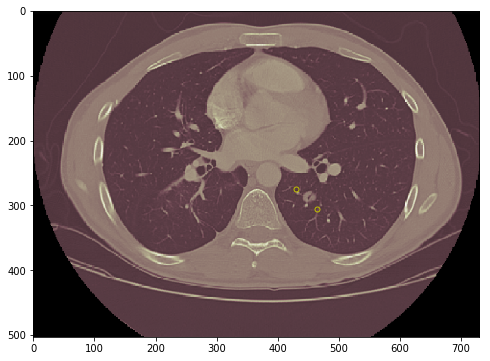

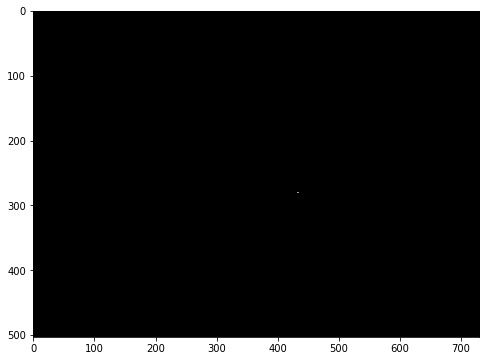

In [11]:
import cv2


img = cv2.imread('Selection_001.png')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

start_x=430
start_y=275
width=35
height=30

rect = (start_x,start_y,width,height)

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(img, cmap=plt.cm.bone, aspect='auto')
ax.plot([start_x,start_x+width],[start_y,start_y+height], 'ro',  markersize=5, markerfacecolor='none', markeredgecolor='y')
plt.show()

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]


fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(img, cmap=plt.cm.bone, aspect='auto')
plt.show()
